In [28]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [29]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats

In [30]:
from datetime import datetime
import datetime as dt
from dateutil.relativedelta import relativedelta

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [32]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo = False)

In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [34]:
Base.classes.keys()

['measurement', 'station']

In [35]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [37]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [39]:
columns = inspector.get_columns('station')
for cl in columns:
    print(cl['name'], cl['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [40]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#session.query(func.count(Measurement.date)).all()

last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_data_point

# session.query(func.extract(Topic.date_created, 'year'))

('2017-08-23')

In [53]:
year_ago = dt.date(2018,5,23) - dt.timedelta(days= 365)
print(year_ago)

2017-05-23


In [54]:
# Perform a query to retrieve the data and precipitation scores
# sel = [Measurement.date, 
#        func.avg(Measurement.prcp)]
# year_prcp = session.query(*sel).\

year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago, Measurement.prcp != None).\
    order_by(Measurement.date).all()
#     group_by(Measurement.date).\

In [55]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(year_prcp, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head()

,Precipitation
Date,
2017-05-23,0.08
2017-05-23,0.02
2017-05-23,0.11
2017-05-23,0.00
2017-05-23,0.06


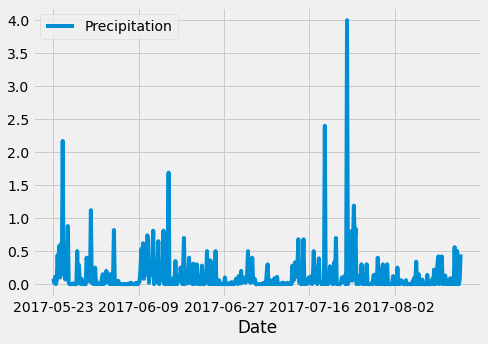

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(7,5))
plt.tight_layout()
plt.savefig('Precipitation.png')